In [18]:
# project - part b


# Import packages
import numpy as np
import simpy
from pylab import plot, bar, show
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import random


class Visitor(object): # class of visitor
    def __init__(self, visitor_id):
        self.v_id = visitor_id # visitor ID
        self.begin_money = 0 # With how much money the visitor has arrived
        self.v_arrive = 0 # When the visitor has arrived
        self.v_enjoy = 10.0 # an initial value of enjoy for a visitor
        self.list_of_like_game = [np.random.uniform(1, 5) for i in range(3)]  # get value for every level of like of each game
        self.random_uni = np.random.uniform(0, 1)
        if self.random_uni <= 0.9: # there is 90% chance that the visitor is a regular type
            self.type = 'R'
        else: # there is 10% chance that the visitor is a VIP type
            self.type = 'V'
        self.returns = 0 # how many times the visitor returns to the casino
        self.day_profit = [0 for i in range(30)] # a list that will have visitor's profit for every day
        self.day_enjoy = [1 for i in range(30)] # a list that will have visitor's enjoy for every day
        self.current_money = 0 # how much money the visitor have at this moment
        self.v_quit = 0 # how many time the visitor quit from a line, every visit


class Machine: # class of machine
    def __init__(self, machine_id, env):
        self.m_id = machine_id # machine ID
        self.is_work = True # variable that tells if the machine works
        self.time_broken = 0 # when the machine has broken
        self.machine_resource = simpy.Resource(env, capacity=1) # define machine as resource



class Simulation: # class of the simulation - the main class
    def __init__(self, env):
        self.env = env
        # self.V=0
        self.visitors = [Visitor(j) for j in range(1,10001)] # variable that containing a list of all visitors in the system
        self.machine = [Machine(j, env) for j in range(1,49)] # variable that containing a list of all machines in the casino
        self.Lq_security = [] # list that contain how many visitors are standing in security line
        self.Lq_roulette = [] # list that contain how many visitors are standing in roulette line
        self.Lq_lucky = [] # list that contain how many visitors are standing in lucky machine line
        self.Lq_shoot501 = [] # list that contain how many visitors are standing in shoot501 line
        self.how_many_broken_machine = 0 # variable that contain how many broken machines there are in the casino
        self.daily_quit_amount = 0 # variable that contain how many visitors has quieted from line in specific day
        self.quit_list = [0 for i in range(30)] # variable that contain how many visitors has quieted from line each day
        self.security_man = simpy.Resource(env, capacity=1) # define security man as resource
        self.game_roulette = simpy.Resource(env, capacity=10) # define roulette as resource
        self.game_shoot501 = simpy.Resource(env, capacity=10) # define shoot501 as resource
        self.monthly_security = [0 for i in range(30)] # list that contain how many visitors are standing in security line every day
        self.monthly_roulette = [0 for i in range(30)] # list that contain how many visitors are standing in roulette line every day
        self.monthly_lucky = [0 for i in range(30)] # list that contain how many visitors are standing in lucky line every day
        self.monthly_shoot501 = [0 for i in range(30)] # list that contain how many visitors are standing in shoot501 line every day
        self.monthly_enjoy = [0 for i in range(30)] # list that contain the level of visitor's enjoy every day
        self.monthly_profit = [0 for i in range(30)] # list that contain casino's daily revenue
        self.total_monthly_profit = [0 for i in range(30)] # list that contain casino's daily profit
        self.L=0 # variable that count how many visitors are entering the casino every day
        self.money_food = 0 # variable that contain money that the casino will earned from the food that sold
        self.money_drink = 0 # variable that contain money that the casino will earned from the drinks that sold


    def initial_broken(self):  # function reset the first broken
        for machine in self.machine: #running over every machine in the casino
            self.env.process(self.broken_machine(machine)) #sending to "broken machine" function
            yield self.env.timeout(2 / (60 * 60))  # 2 sec between each broken machine

    def broken_machine(self, machine): # function that makes the machine broken
        while True: # while the simulation is runing
            machine.time_broken = np.random.exponential(7 * 24) # creating time that the machine will be broke by exp distribution
            yield self.env.timeout(machine.time_broken)  # hold the machine until "time broken" will pass
            machine.is_work = False # update that the machine is broken
            self.how_many_broken_machine += 1 # adding the broken machine to the counter
            if len(machine.machine_resource.users)==1: # checking if the visitor playing on the machine while it brokes
                self.play.interrupt() # if the machine work - we need to interrupt the game
            if len(machine.machine_resource.queue)!=0: # checking if there is a line for the broken machine
                self.env.process(self.line_lucky(machine.machine_resource.queue, self.env)).interrupt() #if there is a line, we need tu interrupt it
            self.env.process(self.fix_machine(machine)) #sending to "fix machine" function

    def fix_machine(self, machine): # function that fix the machine
        fix_time = np.random.triangular(2, 13, 24)  # creating time that the machine will be fix by triangular distribution
        yield self.env.timeout(fix_time) # hold the machine until "fix time" will pass
        machine.is_work = True  # update that the machine has been fixed
        machine.time_broken = 0  # update broken time
        self.how_many_broken_machine -= 1 # remove the broken machine off the counter
        self.broken_machine(machine) # sending to "broken machine" function

    def initial_arrival(self): # function that reset the first arrival
        for visitor in self.visitors: #running over every visitor in the system
            self.env.process(self.visitor_arrival(visitor)) #sending to "visitor arrival" function
            yield self.env.timeout(10 / (60 * 60))  # 10 sec between each visitor

    def line_security(self, visitor): #function that contain the security line
        with self.security_man.request() as req:
            # Request the security man
            yield req # hold the visitor, as long he didn't get the security man

    def visitor_arrival(self, visitor): # function that definig the visitor's arrival
        if visitor.returns == 0:  # first arrival
            yield self.env.timeout(np.random.exponential(72)) # creating visitor's arrival by triangular distribution
            visitor.returns += 1  # if visitor getting back the casino he WONT come again to initial arrival
            if visitor.type == 'V':  # if the visitor is VIP type
                visitor.begin_money = np.random.normal(10000, 1000)  # get initial money from normal distribution
                visitor.current_money = visitor.begin_money # updating the begin money of the visitor in the current money
                visitor.v_arrive = self.env.now # updating the arrival time to the casino
                self.L += 1 # adding visitor that entering to the casino
                (self.check_money(visitor))  # sending VIP to "check money" function, without passing over the security man
            else: # if the visitor is regular type
                visitor.begin_money = np.random.normal(250, 25)  # get initial money from normal distribution
                visitor.current_money=visitor.begin_money # updating the begin money of the visitor in the current money
                patience = self.env.timeout(1) # visitor will wait until 1 hour to the security man
                with self.security_man.request() as sec: # visitor request the security man
                    result=yield sec|patience
                    if sec not in result: # visitor didn't get the security man, his patience has done
                        self.daily_quit_amount += 1  # adding one more visitor that quit - to a variabla that contain daily sum of quiters
                        visitor.v_enjoy -=0.01 # since the visitor quit, it will damage the enjoy
                        self.env.process(self.leaving(visitor)) # sending visitor to "leaving" function
                    else: # visitor get the resource "security man" before 1 hour left
                        self.Lq_security.append(len(self.security_man.queue)) # adding the len of the security man's queue
                        yield self.env.timeout(30 / (60 * 60)) # creating the security check, that takes 30 sec
                        self.L += 1  # adding visitor that entering to the casino
                        visitor.v_arrive = self.env.now # updating the arrival time to the casino
                        self.check_money(visitor) # sending regular to "check money" function
        else:  # regular arrival
            visitor.returns += 1 # adding returns to the visitor
            if visitor.type == 'V': # if the visitor is VIP type
                visitor.begin_money = (np.random.normal(10000,
                                                        1000)) * visitor.returns  # get initinal money from (normal distribution * sum of returns)
                visitor.v_arrive = self.env.now # updating the arrival time to the casino
                visitor.current_money = visitor.begin_money # updating the begin money of the visitor in the current money
                self.L += 1 # adding visitor that entering to the casino
                self.check_money(visitor)  # sending VIP to "check money" function, without passing over the security man
            else: # regular visitor
                visitor.begin_money = np.random.normal(250, 25) * visitor.returns  # get initinal money from (normal distribution * sum of returns)
                visitor.current_money = visitor.begin_money  # updating the begin money of the visitor in the current money
                patience = self.env.timeout(1) # visitor will wait until 1 hour to the security man
                with self.security_man.request() as sec: # visitor request the security man
                    result = yield sec | patience
                    if sec not in result: # visitor didn't get the security man, his patience has done
                        self.daily_quit_amount += 1  # adding one more visitor that quit - to a variabla that contain daily sum of quiters
                        visitor.v_enjoy -= 0.01  # since the visitor quit, it will damage the enjoy
                        self.env.process(self.leaving(visitor)) # sending regular to "check money" function
                    else: # visitor get the resource "security man" before 1 hour left
                        self.Lq_security.append(len(self.security_man.queue))  # adding the len of the security man's queue
                        yield self.env.timeout(30 / (60 * 60)) # creating the security check, that takes 30 sec
                        self.L += 1 # adding visitor that entering to the casino
                        visitor.v_arrive = self.env.now # updating the arrival time to the casino
                        self.check_money(visitor) # sending regular to "check money" function


    def check_money(self, visitor):  # check if the visitor has enough money
        like = np.random.uniform(0, 1)  # varibale that will help up choose witch game the visitor likes the most
        for game in range(len(visitor.list_of_like_game)): # running over the games
            if visitor.list_of_like_game[game] > 5: # checking if there is a game that its like level over 5
                visitor.list_of_like_game[game] = 5 # the maximum of level like is 5
            if visitor.list_of_like_game[game] < 1: # checking if there is a game that its like level under 5
                visitor.list_of_like_game[game] = 1 # the minimum of level like is 1
        if visitor.current_money < 1: # if the visitor has only left 1 shekel
            self.env.process(self.leaving(visitor)) # sending the visitor to "visitor" function - doesn't have enough money to play
        elif visitor.current_money >= 1 and visitor.current_money < 5: # checking if the visitor has money between 1 to 5
            self.check_play_lucky(visitor)  # sending the visitor to "check play lucky" function - visitor has enough money to play only lucky machine
        elif visitor.current_money >= 5 and visitor.current_money < 20: #checking if the visitor has money between 5 to 20
            if like <= visitor.list_of_like_game[1] / sum(visitor.list_of_like_game[1:3]): # checking the probability of the level like of lucky and shoot
                self.check_play_lucky(visitor) # sending the visitor to "check play lucky" function - visitor has enough money to play lucky machine
            else:
                self.check_play_shoot501(visitor) # sending the visitor to "check play shoot501" function - visitor has enough money to play shoot501
        else: # the visitor has more than 20 shekel
            if like <= visitor.list_of_like_game[0] / sum(visitor.list_of_like_game):
                self.check_play_roulette(visitor)  # sending the visitor to "check play roulette" function - visitor has enough money to play roulette
            elif like > visitor.list_of_like_game[0] / sum(visitor.list_of_like_game) and like <= sum(
                    visitor.list_of_like_game[0:2]) / sum(visitor.list_of_like_game):
                self.check_play_lucky(visitor)  # sending the visitor to "check play lucky" function - visitor has enough money to play lucky machine
            else:
                self.check_play_shoot501(visitor)  # sending the visitor to "check play shoot501" function - visitor has enough money to play shoot501

    def check_play_roulette(self, visitor): #function that checks if the visitor can play roulette
        time_game = np.random.uniform(230.0 / (60 * 60), 360.0 / (60 * 60)) # get the duration of the game by uniform distribution
        if len(self.game_roulette.users) < 10:  # there is free places in the roulette resoucre - visitor can join the game and there is no line
            if (time_game + (self.env.now - visitor.v_arrive)) > 12:  # checking if there is no time left
                if max(visitor.list_of_like_game) == visitor.list_of_like_game[0]:  # checking if this is the game the visitor like most roulette
                    time_game_again = np.random.uniform(230.0 / (60 * 60), 360.0 / (60 * 60)) # get new duration of the game by uniform distribution
                    if (time_game_again + (self.env.now - visitor.v_arrive)) > 12: # checking if there is no time left
                        self.env.process(self.leaving(visitor)) # sending the visitor to "leaving" function - since there is no time left
                    else: # there is time left to play roulette
                        self.env.process(self.play_roulette(visitor, time_game_again, self.env)) # sending the visitor to "play roulette" function
                else: # it isn't his favorite game
                    self.env.process(self.leaving(visitor)) #the visitor will not get another chance to check if there is enough time to play - sending the visitor to "leaving" function
            else: # there is time left, on the first check
                self.env.process(self.play_roulette(visitor, time_game, self.env)) # sending the visitor to "play roulette" function
        else: # there is a line
            if ((len(self.game_roulette.queue) * (360.0 / (60 * 60)) / 10) + time_game + (
                    self.env.now - visitor.v_arrive) + (360 * 10.0 / (60 * 60))) > 12:  # checking if the visitor will succeed playing before 12 hours left
                if max(visitor.list_of_like_game) == visitor.list_of_like_game[0]:  # checking if this is the game the visitor like most roulette
                    time_game_again = np.random.uniform(230.0 / (60 * 60), 360.0 / (60 * 60)) # get new duration of the game by uniform distribution
                    if ((len(self.game_roulette.queue) * (360.0 / (60 * 60)) / 10) + time_game_again + (
                            self.env.now - visitor.v_arrive) + (360 * 10.0 / (60 * 60))) > 12:  # checking again if the visitor will succeed playing before 12 hours left
                        self.env.process(self.leaving(visitor)) # sending the visitor to "leaving" function - since there is no time left
                    else: # there is time left to play roulette
                        self.env.process(self.play_roulette(visitor, time_game_again, self.env))  # sending the visitor to "play roulette" function
                else: # it isn't his favorite game
                    self.env.process(self.leaving(visitor)) #the visitor will not get another chance to check if there is enough time to play - sending the visitor to "leaving" function
            else: # there is time left, on the first check
                self.env.process(self.play_roulette(visitor, time_game, self.env)) # sending the visitor to "play roulette" function

    def check_play_lucky(self, visitor): #function that checks if the visitor can with the lucky macine
        time_game = np.random.triangular(220.0 / (60 * 60), 300.0 / (60 * 60), 450.0 / (60 * 60))  # get the duration of the game by triangular distribution
        max_line = 0 # variable that contain the length of the machine with the longest line
        if self.how_many_broken_machine == 48:  # checking if all machines are broken
            self.quit_game(visitor)  # all the machines are broken - sending the visitor to quit game function
        else: # not all machines are broken
            for index in range(len(self.machine)): #running over all machines thats are in the casino
                if len(self.machine[index].machine_resource.queue) > max_line and self.machine[index].is_work == True: # checking if the machine works and if its line is the maximum line
                    max_line = len(self.machine[index].machine_resource.queue) # updating the length of the machine with the longest line
            if max_line == 0:  # checking if there is no line in every machine
                if (time_game + (self.env.now - visitor.v_arrive)) > 12:  # checking if there is also no time (and no line)
                    coin = np.random.uniform(0, 1) # throwing a coin that will help the visitor to choose if to check time again or not
                    if coin <= 0.5:  # probability of up to 0.5 chance to play
                        time_game_again = np.random.triangular(220.0 / (60 * 60), 300.0 / (60 * 60), 450.0 / (60 * 60)) # get new duration of the game by triangular distribution
                        if (time_game_again + (self.env.now - visitor.v_arrive)) > 12:  # checking if there is enough time to play with the new duration
                            self.env.process(self.leaving(visitor)) # not wnough time to play - sending the visitor to "leaving" function
                        else: # there is enough time to play
                            self.env.process(self.play_lucky(visitor, time_game_again, self.env))  # sending the visitor to play "lcuky function" - the visitor can play lucky machine
                    else: # probability of 0.5 up to 1 chance to leave
                        self.env.process(self.leaving(visitor)) # sending the visitor to "leaving" function
                else: # there is enough time to play lucky machine
                    self.env.process(self.play_lucky(visitor, time_game, self.env)) # sending the visitor to "play lucky" function
            else:  # there is line
                if (max_line * (450.0 / (60 * 60)) + time_game + (self.env.now - visitor.v_arrive) + (
                        450.0 / (60 * 60))) > 12: # checking if there is enough time to play with the duration
                    coin = np.random.uniform(0, 1) # throwing a coin that will help the visitor to choose if to check time again or not
                    if coin <= 0.5:  # probability of up to 0.5 chance to play
                        time_game_again = np.random.triangular(220.0 / (60 * 60), 300.0 / (60 * 60), 450.0 / (60 * 60)) # get new duration of the game by triangular distribution
                        if (max_line * (450.0 / (60 * 60)) + time_game_again + (self.env.now - visitor.v_arrive) + (
                                450.0 / (60 * 60))) > 12: # checking if there is enough time to play with the new duration
                            self.env.process(self.leaving(visitor))  #sending visitor to "leaving" function
                        else: # there is enough time to play
                            self.env.process(self.play_lucky(visitor, time_game_again, self.env))   # sending the visitor to "play lcuky" function - the visitor can play lucky machine
                    else: # probability of 0.5 up to 1 chance to leave
                        self.env.process(self.leaving(visitor))  #sending visitor to "leaving" function
                else: # there is enough time to play lucky machine
                    self.env.process(self.play_lucky(visitor, time_game, self.env))  # sending the visitor to "play lucky" function

    def check_play_shoot501(self, visitor): # checking if the visitor can play shoot501
        time_game = np.random.uniform(180.0 / (60 * 60), 240.0 / (60 * 60)) # get the duration of the game by uniform distribution
        if len(self.game_shoot501.users) < 10:  # there is free places in the shoot501 resoucre - visitor can join the game and there is no line
            if (time_game + (self.env.now - visitor.v_arrive)) > 12:  # checking if there is no time left
                if (visitor.current_money % 2) == 0:  # checking if visitor's money divide by two - if it does - the visitor can check the time again
                    time_game_again = np.random.uniform(180.0 / (60 * 60), 240.0 / (60 * 60)) # get new duration of the game by triangular distribution
                    if (time_game_again + (self.env.now - visitor.v_arrive)) > 12:  # checking if there is enough time to play with the new duration
                        self.env.process(self.leaving(visitor)) #sending visitor to "leaving" function
                    else: # there is time to play
                        self.env.process(self.play_shoot501(visitor, time_game_again, self.env)) # sending the visitor to "play shoot501" function - the visitor can play shoot501
                else: # the visitor's money doesn't divide by two
                    self.env.process(self.leaving(visitor)) #sending visitor to "leaving" function
            else: # there is enough time
                self.env.process(self.play_shoot501(visitor, time_game, self.env))  # sending the visitor to "play shoot501" function - the visitor can play shoot501
        else: # there is a line
            if ((len(self.game_shoot501.queue) * (240.0 / (60 * 60)) / 10) + time_game + (
                    self.env.now - visitor.v_arrive) + (240.0 * 10) / (60 * 60)) > 12:  # checking if there is no time left
                if (visitor.current_money % 2) == 0:  # checking if visitor's money divide by two - if it does - the visitor can check the time again
                    time_game_again = np.random.uniform(180.0 / (60 * 60), 240.0 / (60 * 60)) # get new duration of the game by triangular distribution
                    if ((len(self.game_shoot501.queue) * (240.0 / (60 * 60)) / 10) + time_game_again + (
                            self.env.now - visitor.v_arrive) + (240.0 * 10) / (60 * 60)) > 12: # checking if there is enough time to play with the new duration
                        self.env.process(self.leaving(visitor)) #sending visitor to "leaving" function
                    else: # there is time to play
                        self.env.process(self.play_shoot501(visitor, time_game_again, self.env)) # sending the visitor to "play shoot501" function - the visitor can play shoot501
                else: # the visitor's money dooesn't divide by two
                    self.env.process(self.leaving(visitor)) #sending visitor to "leaving" function
            else: # there is enough time
                self.env.process(self.play_shoot501(visitor, time_game, self.env)) # sending the visitor to "play shoot501" function - the visitor can play shoot501

    def line_roulette(self, env): #function that contain the roulette line
        with self.game_roulette.request() as req:
            # Request the game roulette
            yield req # hold the visitor, as long he didn't get the game roulette

    def line_lucky(self, list_line, env): #function that contain the lucky machine line
        try:
            with self.machine[self.index_short_line].machine_resource.request() as req:
                # Request the lucky machine
                yield req # hold the visitor, as long he didn't get the lucky machine
        except simpy.Interrupt: # if the machine suddenly broked - we need to interrupt the line
            for visit in list_line: # running over every visitor that standing in the line
                self.quit_game(visit) # sending every visitor that standing in the line - to "quit game" function

    def line_shoot501(self, env): #function that contain the shoot501 line
        with self.game_shoot501.request() as req:
            # Request the game shoot501
            yield req # hold the visitor, as long he didn't get the game shoot501

    def play_roulette(self, visitor, time_game, env):  # function of the game roulette
        visitor_quit = np.random.uniform((25.0 / ((60.0) * (visitor.v_quit + 1))), (
                40.0 / ((60.0) * (visitor.v_quit + 1))))  # varibale that get the duration until the visitor will quit the line - from uniform distribution
        self.Lq_roulette.append(len(self.game_roulette.queue)) # adding the len of the security man's queue
        patience = env.timeout(visitor_quit) # variable that contain how much time the visitor will wait at line
        with self.game_roulette.request() as rul: # request the game roulette
            result = yield rul|patience
            if patience not in result: #checking if the visitor finished standing in line before his patience over - the visitor can play the roulette
                if visitor.type == 'V': # checking if the visitor's type is VIP
                    amount = 40 # VIP visitor gives 40 shekel to start play
                else: #visitor is from regular type
                    amount = 20 # regular visitor gives 20 shekel to start play
                visitor.current_money -= amount  # the visitor paying for the game
                num = np.random.uniform(0, 1) # getting a number from uniform distribution
                if num <= 0.5:  # first option for roulette game - choosing number
                    visitor_choose = round(np.random.uniform(1, 38)) # visitor chooses for the game
                    roulette_choose = round(np.random.uniform(1, 38)) # what the roulette chooses
                    if visitor_choose == roulette_choose: # checking if the visitor choose the same number as the roulette - if he does - he wins
                        visitor.current_money += (amount * 35)  # visitor get money - he won
                        visitor.v_enjoy += 0.5 # since the visitor won - he is adding more enjoy
                        visitor.list_of_like_game[0] += 5 # since the visitor won - he is adding level to his like level for this game
                        yield self.env.timeout(time_game)  # holding the visitor until the duratin of the game finish
                        self.check_money(visitor)  # sending the visitor to "check money" function - to check id he can play again
                    else:  # visitor loses
                        visitor.list_of_like_game[0] -= 0.25 # visitor loses some level from the level like of this game
                        yield self.env.timeout(time_game)  # holding the visitor until the duration of the game finish
                        self.check_if_stay(visitor) # sending the visitor to "check if stay" function
                else:  # second option for roulette game - choosing color
                    visitor_choose = np.random.uniform(0, 1) # visitor chooses for the game
                    if visitor_choose <= 0.5:
                        visitor_color = 'red'  # visitor wants red color
                    else:
                        visitor_color = 'black'  # visitor wants black color
                    roulette_choose = np.random.uniform(0, 1)  # what the roulette chooses
                    if roulette_choose <= (18.0 / 38.0):
                        roulette_color = 'red'  # roulette returns red color
                    elif roulette_choose > (18.0 / 38.0) and roulette_choose <= (36.0 / 38.0):
                        roulette_color = 'black'  # roulette returns black color
                    else:
                        roulette_color = 'green'  # roulette returns green color
                    if visitor_color == roulette_color:  # checking if the visitor choose the same color as the roulette - if he does - he wins
                        visitor.current_money += (amount * 2) # visitor get money - he won
                        visitor.v_enjoy += 0.05 # since the visitor won - he is adding more enjoy
                        visitor.list_of_like_game[0] += 0.5  # since the visitor won - he is adding level to his like level for this game
                        yield self.env.timeout(time_game)  # holding the visitor until the duration of the game finish
                        self.check_money(visitor)   # sending the visitor to "check money" function - to check id he can play again
                    else:  # visitor loses
                        visitor.list_of_like_game[0] -= 0.75 # visitor loses some level from the level like of this game
                        yield self.env.timeout(time_game)  # holding the visitor until the duration of the game finish
                        self.check_if_stay(visitor) # sending the visitor to "check if stay" function
            else: # if the patience finish before the line done
                self.quit_game(visitor) # sending the visitor to quit game function

    def play_lucky(self, visitor, time_game, env):  # function of the game lucky machine
        self.index_short_line = 0 # variable that contain the id of the machine that has the shorter line
        short_line = 10000 # variable that contain the length of the line
        visitor_start_money = visitor.current_money #updating the start money of the visitor ar the lucky machine
        for index in range(len(self.machine)): #running over all machines that are in the casino
            if len(self.machine[index].machine_resource.queue) < short_line and self.machine[index].is_work==True: #checking if the length of a specific machine is shortet than the variable "short line" and the machine must work
                short_line = len(self.machine[index].machine_resource.queue) #updating the value of the length of the shorter line
                self.index_short_line = index #updating the ID of the machine of the shorter line
        visitor_quit = np.random.uniform((25.0 / ((60.0) * (visitor.v_quit + 1))), (
                40.0 / ((60.0) * (visitor.v_quit + 1))))  # varibale that get the duration until the visitor will quit the line - from uniform distribution
        for machine in self.machine: #running over all machines that are in the casino
            self.Lq_lucky.append(len(machine.machine_resource.queue)) #updating the list of the length of the line
        patience = env.timeout(visitor_quit) # variable that contain how much time the visitor will wait at line
        line = env.process(self.line_lucky(self.machine[self.index_short_line].machine_resource.queue, env)) # varibale that sending the chosen machine to "line lucky" function
        self.play = env.process(self.time_to_play_lucky(visitor, time_game, env)) # variable that sending the visitor to play with the lucky machine
        result = yield patience |line
        if patience in result: # checking if the patience finished first
            line.interrupt(visitor) # the patience finished first, we need to interrupt the line
        elif line in result:  # visitor's turn came first
            yield self.play # holding the visitor to play without interrupt
            if visitor_start_money > visitor.current_money: # checking if the visitor loses
                self.check_if_stay(visitor) # visitor loses - sending the visitor to "check if stay" function
            else: # the visitor wins
                self.check_money(visitor)  # sending the visitor to "check money" function

    def time_to_play_lucky(self, visitor, time_game, env): # function that describes the lucky machine game
        try:
            if visitor.type == 'V': # checking the visitor's type - if he is VIP
                amount = 2 # VIP visitor gives 2 shekel to start play
            else: # visitor's type is regular
                amount = 1 # regular visitor gives 1 shekel to start play
            visitor.current_money -= amount  # paying for play with lucky machine
            num = np.random.uniform(0, 1) # variable that contain number from uniform distribution
            if num <= 0.5: # visitor loses
                visitor.v_enjoy -= 0.01 # updating the visitor's enjoy since the visitor lost
                visitor.list_of_like_game[1] -= 0.05 # updaing the level of the level like of this game
                yield self.env.timeout(time_game) # holding the visitor until the duration game finish
            elif num > 0.5 and num <= 0.8: # visitor wins
                visitor.current_money += 1  # visitor gets money
                visitor.v_enjoy += (1 * 0.01) # updating visitor's enjoy - since he won
                visitor.list_of_like_game[1] += (1 * 0.05) # updating visitor's the level of the level like of this game
                yield self.env.timeout(time_game)  # holding the visitor until the duration game finish
            elif num > 0.8 and num <= 0.95: # visitor wins
                visitor.current_money += 5  # visitor gets money
                visitor.v_enjoy += (5 * 0.01) # updating visitor's enjoy - since he won
                visitor.list_of_like_game[1] += (5 * 0.05) # updating visitor's the level of the level like of this game
                yield self.env.timeout(time_game) # holding the visitor until the duration game finish
            elif num > 0.95 and num <= 0.99: # visitor wins
                visitor.current_money += 50  # visitor gets money
                visitor.v_enjoy += (50 * 0.01)  # updating visitor's enjoy - since he won
                visitor.list_of_like_game[1] += (50 * 0.05)  # updating visitor's the level of the level like of this game
                yield self.env.timeout(time_game) # holding the visitor until the duration game finish
            else: # visitor wins
                visitor.current_money += 100  # visitor gets money
                visitor.v_enjoy += (100 * 0.01)  # updating visitor's enjoy - since he won
                visitor.list_of_like_game[1] += (100 * 0.05)  # updating visitor's the level of the level like of this game
                yield self.env.timeout(time_game)  # holding the visitor until the duration game finish
        except simpy.Interrupt: # if there is an Interrupt
            self.quit_game(visitor) # sending the visitor to "quit game" function

    def play_shoot501(self, visitor, time_game, env): # function that describes the shoot501 game
        visitor_quit = np.random.uniform((25.0 / ((60.0) * (visitor.v_quit + 1))), (
                40.0 / ((60.0) * (visitor.v_quit + 1))))   # varibale that get the duration until the visitor will quit the line - from uniform distribution
        self.Lq_shoot501.append(len(self.game_shoot501.queue)) #updating the list of the length of the line
        patience = env.timeout(visitor_quit) # variable that contain how much time the visitor will wait at line
        with self.game_shoot501.request() as shoot501: # request the game shoot501
            result=yield patience|shoot501
            if not patience in result: #checking if the visitor finished standing in line before his patience over - the visitor can play the shoot501
                if visitor.type == 'V': # checking if the visitor's type is VIP
                    amount = 10 # VIP visitor gives 10 shekel to start play
                else: # visitor's type is regular
                    amount = 5 # regular visitor gives 5 shekel to start play
                visitor.current_money -= amount  # paying the game to play shoot501
                num_of_darts = 3 # variable that contain how many darts left to the visitor - he starts with 3
                start_score = 60 # variable that contain how many points left to the visitor - he starts with 60
                hit_score = 0 # variable that contain how many pionts the visitor hits
                num_darts = 0 # variable that contain how many darts the visitor used
                for dart in range(num_of_darts): #running over the darts
                    hit_num = round(np.random.uniform(1, 20)) # variable that contain where the visitor hits
                    hit = np.random.uniform(0, 1) # variable that contain the board with the point
                    num_darts += 1 # the visitor used one dart each turn
                    if hit <= 0.01:  # visitor hits middle red dot
                        hit_score = 50 # visitor gets 50 points
                    if hit > 0.01 and hit <= 0.05:  # visitor hits middle green ring
                        hit_score = 25 # visitor gets 25 points
                    if hit > 0.05 and hit <= 0.15:  # visitor hits outside ring (the big ring)
                        hit_score = hit_num * 2 # visitor gets 2*(the number the visitor hits) points
                    if hit > 0.15 and hit <= 0.25:  # visitor hits inside ring (the small ring)
                        hit_score = hit_num * 3 # visitor gets 3*(the number the visitor hits) points
                    if hit > 0.25 and hit <= 0.50:  # visitor missed
                        hit_score = 0 # visitor gets 0 points
                    if hit > 0.50:  # visitor hits the exact number that writen on board
                        hit_score = hit_num # visitor gets the point he hits
                    if start_score - hit_score > 0: # checking if the visitor succeed to hit the board - if the final score is positive
                        start_score -= hit_score # the visitor hits to board - updating his points
                    elif start_score - hit_score < 0: # if the final score is negative
                        start_score = -(start_score - hit_score) # updatin this points - and return the score to positive points
                    else: # visitor succeeds to finish his points
                        start_score = 0 #the visitor finish the game
                        break
                if start_score == 0: # visitor wins
                    visitor.current_money += 60  # visitor get money
                elif start_score == 1: # visitor wins
                    visitor.current_money += 20  # visitor get money
                elif start_score == 2: # visitor wins
                    visitor.current_money += 15  # visitor get money
                elif start_score == 3: # visitor wins
                    visitor.current_money += 10  # visitor get money
                elif start_score == 4: # visitor wins
                    visitor.current_money += 5  # visitor get money
                else: # visitor loses
                    visitor.current_money += 0 # visitor doesn't get money
                if start_score <= 4: # visitor wins
                    visitor.v_enjoy += 0.1 * (4 - num_darts) # updating visitor's enjoy since he won
                    visitor.list_of_like_game[2] += 0.5 * (4 - num_darts) # updating visitor's level like of this game since he won
                    yield self.env.timeout(time_game)  # holding visitor until the game's duration finish
                    self.check_money(visitor)  # sending the visitor to "check money" function
                else:  # visitor loser
                    visitor.v_enjoy -= 0.01 * (4 - num_darts) # updating visitor's enjoy since he lost
                    visitor.list_of_like_game[2] -= 0.05 * (4 - num_darts) # updating visitor's level like of this game since he lost
                    yield self.env.timeout(time_game) # holding visitor until the game's duration finish
                    self.check_if_stay(visitor) # sending the visitor to "check if stay" function
            else: # patience finish first
                self.quit_game(visitor) # sending the visitor to "wuit game" function

    def check_if_stay(self, visitor):  # function that check if the visitor will stay in the casino
        enjoy = float(1 - (1 / float(visitor.v_enjoy)))  # variable that makes normalize to visitor's enjoy
        time = self.env.now - visitor.v_arrive  # variable that contain how long the visitor stayed in the casino
        stay = float((enjoy * (12 - time)) / 12)  # function that help us to check if the visitor will stay
        stay_result = np.random.uniform(0, 1)  # variable that check if the visitor will stay - choosing number by uniform distribution
        if stay >= stay_result:  # the visitor stays
            self.check_money(visitor) # sending the visitor to "check money" function
        else:  # the visitor choose to left
            self.env.process(self.leaving(visitor)) # sending the visitor to "leaving" function

    def quit_game(self, visitor):  # function that check if the visitor will quit the game
        visitor.v_enjoy -= 0.2 # since the visitor quit, it will damage the enjoy
        visitor.v_quit += 1 # updating the variable that contain how many times the visitor quitted while he was in the casino at the specific day
        self.daily_quit_amount += 1 # updating the variacle that contain how many times all the visitor that came the speceific day - quitted
        if visitor.v_quit < 3:  # if visitor didn't quit over 3 times - visitor stays
            self.check_money(visitor) # sending the visitor to "check money" function
        else: # visitor quitted over 3 times already - visitor leaves
            self.env.process(self.leaving(visitor))  # sending the visitor to "leaving" function

    def leaving(self, visitor):  # function that helps the visitor to leave the casino
        current_day = int(self.env.now / 24.0) # checking which day is it
        visitor.day_profit[current_day] = (visitor.begin_money - visitor.current_money)  # updating the visitor profit
        self.monthly_profit[current_day] += (visitor.begin_money - visitor.current_money) # updaing the casino profit
        visitor.v_quit = 0 # reset the variable that contain how many times the visitor quitted at the specific day
        visitor.begin_money = 0 # reset the variable that contain how much money the visitor came to the casino at the specific day
        visitor.current_money = 0 # reset the variable that contain how much money the visitor has now at the specific day
        visitor.v_arrive = 0 # reset the variable that contain when the visitor came to the casino at the specific day
        if visitor.v_enjoy >= 20: # visitor's enjoy is between 1 to 20 - if it is over 20
            visitor.v_enjoy = 20 # updating visitor's enjoy to 20
        if visitor.v_enjoy < 1: # visitor's enjoy is between 1 to 20 - if it is under 1
            visitor.v_enjoy = 1 # updating visitor's enjoy to 1
        for index in range(current_day, 30): # running over the days that have left
            if current_day == 0: # checking if it is the first day
                visitor.day_enjoy[index] = (visitor.v_enjoy / 10.0) # updaint the list that contain visitor's enjoy by evrey day
            else: # it is not the first date
                if current_day == 1: # checking if it is the second day
                    visitor.day_enjoy[index] = (
                            (visitor.v_enjoy) / ((visitor.day_enjoy[current_day - 1]) * 10))  # updaint the list that contain visitor's enjoy by evrey day
                else:
                    visitor.day_enjoy[index] = (
                            (visitor.v_enjoy) / ((sum(visitor.day_enjoy[current_day - 2:current_day])) * 5))  # updaint the list that contain visitor's enjoy by evrey day
        money_food = np.random.triangular(42.3,106.0999999999979,187.1) # we found a b c from the excel - how much the visitor spent on food
        self.money_food += money_food
        money_drink = np.random.normal(79.82118281353995,37.676755925093445**2)#################################
        self.money_drink += money_drink
        yield (self.env.timeout(max(0, (np.random.exponential(72)) / ((visitor.v_enjoy) / 10)))) # creating the next arrival of the visitor
        self.env.process(self.visitor_arrival(visitor)) # sending the visitor to "visitor arrival" function

    def daily_quits_amount(self): # function that measuring how many visitors quit the line
        day = (-1) # variable that will be update by every day
        while True: # as long the simulation is running
            if self.env.now == 696: # checking if we are at the 30th day
                yield self.env.timeout(23) # hold until the day will pass
                self.quit_list[-1] = self.daily_quit_amount  # updating the list that contain how many visitors quit every day
            yield self.env.timeout(24)  # every 24 hours creat a sum of quiter visitors
            day += 1 # updating the day
            self.quit_list[day] = self.daily_quit_amount  # updating the list that contain how many visitors quit every day
            self.daily_quit_amount = 0 # reset the variable that contain how many visitors quit at the speceific day

    def average_daily_Lq(self): # function that measuring how many visitors quit the line
        day = (-1)  # variable that will be update by every day
        while True: # as long the simulation is running
            if self.env.now == 696: # checking if we are at the 30th day
                yield self.env.timeout(23) # hold until the day will pass
                self.monthly_security[-1] = (sum(self.Lq_security) / (len(self.Lq_security) + 0.5)) # updating the list that contain how many visitors stay in security line every day
                self.monthly_shoot501[-1] = (sum(self.Lq_shoot501) / (len(self.Lq_shoot501) + 0.5)) # updating the list that contain how many visitors stay in shoot501 line every day
                self.monthly_lucky[-1] = (sum(self.Lq_lucky) / (len(self.Lq_lucky) + 0.5)) # updating the list that contain how many visitors stay in lucky machine line every day
                self.monthly_roulette[-1] = (sum(self.Lq_roulette) / (len(self.Lq_roulette) + 0.5)) # updating the list that contain how many visitors stay in roulette line every day
            yield self.env.timeout(24)  # every 24 hours creat a sum of visitors that standing in line
            day += 1 # updating the day
            self.monthly_security[day] = (sum(self.Lq_security) / (len(self.Lq_security) + 0.5)) # updating the list that contain how many visitors stay in security line every day
            self.monthly_shoot501[day] = (sum(self.Lq_shoot501) / (len(self.Lq_shoot501) + 0.5)) # updating the list that contain how many visitors stay in shoot501 line every day
            self.monthly_lucky[day] = (sum(self.Lq_lucky) / (len(self.Lq_lucky) + 0.5))  # updating the list that contain how many visitors stay in lucky machine line every day
            self.monthly_roulette[day] = (sum(self.Lq_roulette) / (len(self.Lq_roulette) + 0.5))  # updating the list that contain how many visitors stay in roulette line every day
            self.Lq_roulette = [] # reset the variable that contain how many visitors standed in roulette line at the speceific day
            self.Lq_security = [] # reset the variable that contain how many visitors standed in security line at the speceific day
            self.Lq_shoot501 = [] # reset the variable that contain how many visitors standed in shoot501 line at the speceific day
            self.Lq_lucky = [] # reset the variable that contain how many visitors standed in lucky line at the speceific day

    def daily_total_enjoy(self): # function that measuring the visitors's enjoy
        day = (-1) # variable that will be update by every day
        summery = 0
        while True:  # as long the simulation is running
            if self.env.now == 696: # checking if we are at the 30th day
                yield self.env.timeout(23) # hold until the day will pass
                for visitor in self.visitors: # running over all visitors in the system
                    if visitor.day_enjoy[-1] != visitor.day_enjoy[- 2]: # checking if the visitor came yesterday (the value of visitor's enjoy will change)
                        summery += (visitor.day_enjoy[-1])
                    else:
                        continue
                self.monthly_enjoy[-1] = (summery / self.L) # updating the list that contain visitors's enjoy by every day
            yield self.env.timeout(24)  # every 24 hours creat a sum of enjoy pepole
            day += 1 # updating the day
            for visitor in self.visitors: # running over all visitors in the system
                if day == 0: # checking if we are at the first day
                    summery += (visitor.day_enjoy[day])
                else:
                    if visitor.day_enjoy[day] != visitor.day_enjoy[day - 1]:  # checking if the visitor came yesterday (the value of visitor's enjoy will change)
                        summery += (visitor.day_enjoy[day])
                    else:
                        continue
            self.monthly_enjoy[day] = (summery / self.L) # updating the list that contain visitors's enjoy by every day
            self.L = 0 # reset the variable that conatin how many visitors enterd the casino

    def profit_casino(self):  # function that measuring the visitors's enjoy
        day = (-1)  # variable that will be update by every day
        while True: # as long the simulation is running
            if self.env.now == 696: # checking if we are at the 30th day
                yield self.env.timeout(23) # hold until the day will pass
                short_revenue = (self.monthly_profit[-1]) + self.money_food + self.money_drink # updating the short revenue
                short_expenses = (30 * 24 * 3) + (1 * 40 * 24) + (5000 / 30) + (20000 / 30) # updating the short expenses
                quit_money = self.quit_list[-1] # checking how many visitors quit the line at specific day
                if (self.monthly_security[-1] + self.monthly_shoot501[-1] + self.monthly_roulette[
                    -1] + self.monthly_lucky[-1]) > 50: # checking if the length of all the visitors in all lines - is bigger than 50
                    line_money = (-1) * (
                            self.monthly_security[-1] + self.monthly_shoot501[-1] + self.monthly_roulette[
                        -1] + self.monthly_lucky[-1])
                else:
                    line_money = (self.monthly_security[-1] + self.monthly_shoot501[-1] + self.monthly_roulette[
                        -1] + self.monthly_lucky[-1])
                if self.monthly_enjoy[-1] > self.monthly_enjoy[-2]: # checking if the visitor enjoyed today more than he did yesterday
                    enjoy_money = (self.monthly_enjoy[-1]) ** 2
                else:
                    enjoy_money = (-1) * (self.monthly_enjoy[-1] - self.monthly_enjoy[-2]) * 4
                long_expenses = line_money + enjoy_money # updating the long expenses
                self.total_monthly_profit[-1] = +short_revenue - short_expenses + long_expenses - (
                        quit_money * 0.5) # updating the daily casino's profit by function
            yield self.env.timeout(24)  # every 24 hours creat a sum of quit pepole
            day += 1 # updating the day
            short_revenue = (self.monthly_profit[day])+self.money_food + self.money_drink # updating the short revenue
            short_expenses = (30 * 24 * 3) + (1 * 40 * 24) + (5000 / 30) + (20000 / 30) # updating the short expenses
            quit_money = self.quit_list[day]  # checking how many visitors quit the line at specific day
            if (self.monthly_security[day] + self.monthly_shoot501[day] + self.monthly_roulette[
                day] + self.monthly_lucky[day]) > 50: # checking if the length of all the visitors in all lines - is bigger than 50
                line_money = (-1) * (self.monthly_security[day] + self.monthly_shoot501[day] + self.monthly_roulette[
                    day] + self.monthly_lucky[day])
            else:
                line_money = (self.monthly_security[day] + self.monthly_shoot501[day] + self.monthly_roulette[
                    day] + self.monthly_lucky[day])
            if self.monthly_enjoy[day] > self.monthly_enjoy[day - 1] or day == 0: # checking if the visitor enjoyed today more than he did yesterday or it's the first day
                enjoy_money = (self.monthly_enjoy[day]) ** 2
            else:
                enjoy_money = (-1) * (self.monthly_enjoy[day] - self.monthly_enjoy[day - 1]) * 4
            long_expenses = line_money + enjoy_money  # updating the long expenses
            self.total_monthly_profit[day] = +short_revenue - short_expenses + long_expenses - (
                    quit_money * 0.5)  # updating the daily casino's profit by function
            self.money_food = 0
            self.money_drink = 0


random.seed(42)
# Setup and start the simulation
env = simpy.Environment()
# Create simulation (the _Init_ function)
sim = Simulation(env)
sim.env.process(sim.initial_arrival())
sim.env.process(sim.initial_broken())
sim.env.process(sim.daily_quits_amount())
sim.env.process(sim.average_daily_Lq())
sim.env.process(sim.daily_total_enjoy())
sim.env.process(sim.profit_casino())
# Start process and run
sim.env.run(until=24 * 30)





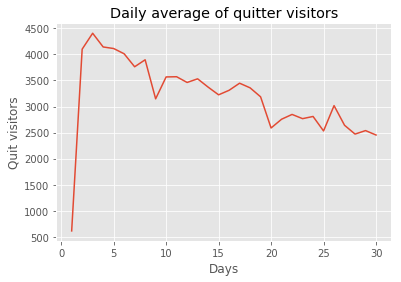

In [19]:
# graph1
days = [day for day in range(1, 31)]
quit_list = sim.quit_list
plt.plot(days, quit_list)
plt.title('Daily average of quitter visitors')
plt.ylabel('Quit visitors')
plt.xlabel('Days')
plt.show()






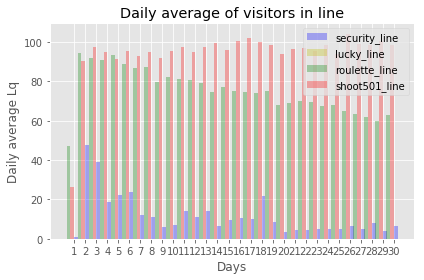

In [20]:
# graph2
days = [day for day in range(1, 31)]

security_line = (sim.monthly_security[0],sim.monthly_security[1],sim.monthly_security[2],sim.monthly_security[3],sim.monthly_security[4],sim.monthly_security[5],sim.monthly_security[6],sim.monthly_security[7],sim.monthly_security[8],sim.monthly_security[9],sim.monthly_security[10],sim.monthly_security[11],sim.monthly_security[12],sim.monthly_security[13],sim.monthly_security[14],sim.monthly_security[15],sim.monthly_security[16],sim.monthly_security[17],sim.monthly_security[18],sim.monthly_security[19],sim.monthly_security[20],sim.monthly_security[21],sim.monthly_security[22],sim.monthly_security[23],sim.monthly_security[24],sim.monthly_security[25],sim.monthly_security[26],sim.monthly_security[27],sim.monthly_security[28],sim.monthly_security[29])
lucky_line = sim.monthly_lucky
roulette_line = sim.monthly_roulette
shoot501_line = sim.monthly_shoot501

fig, ax = plt.subplots()

index = np.arange(30)
bar_width = 0.35

opacity = 0.3
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index+bar_width, security_line, bar_width, alpha=opacity,color='b',label='security_line')

rects2 = ax.bar(index, lucky_line, bar_width,alpha=opacity, color='y',label=('lucky_line'))

rects3 = ax.bar(index-bar_width , roulette_line, bar_width,alpha=opacity, color='g',label=('roulette_line'))

rects4 = ax.bar(index, shoot501_line, bar_width,alpha=opacity, color='r', label=('shoot501_line'))

ax.set_xlabel('Days')
ax.set_ylabel('Daily average Lq')
ax.set_title('Daily average of visitors in line')
ax.set_xticks(index + bar_width/2 )
ax.set_xticklabels(days)
ax.legend()

fig.tight_layout()
plt.show()



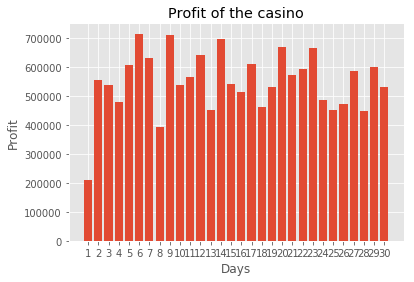

In [21]:
# graph3
days = [day for day in range(1, 31)]
profit = sim.total_monthly_profit


plt.bar(range(len(days)), profit, align='center')
plt.xticks(range(len(days)), days)
plt.xlabel('Days')
plt.ylabel('Profit')
plt.title('Profit of the casino')
plt.show()



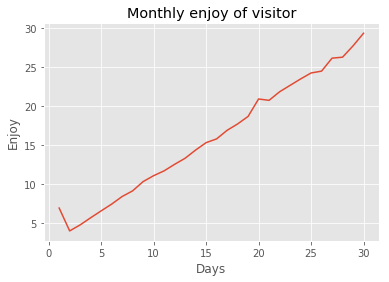

In [22]:
# graph4

days = [day for day in range(1, 31)]
casino_monthly_enjoy = sim.monthly_enjoy
plt.plot(days, casino_monthly_enjoy)
plt.title('Monthly enjoy of visitor')
plt.ylabel('Enjoy')
plt.xlabel('Days')
plt.show()







